# Chapter 6 - Statitstical Machine Learning

In [3]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

# K-Nearest Neighbors
### A Small Example: Predicting Loan Default

In [15]:
# Load the CSV data into a DataFrame
url1 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan200.csv')  
loan200 = pd.read_csv(url1)

loan200.head()

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [17]:
loan200.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outcome            201 non-null    object 
 1   payment_inc_ratio  201 non-null    float64
 2   dti                201 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


In [21]:
predictors = ['payment_inc_ratio', 'dti']    # Define the predictor variables (features)
outcome = 'outcome'                          # Define the target variable

newloan = loan200.loc[0:0, predictors]       # Extract the feature values for the first loan to predict ('newloan')
X = loan200.loc[1:, predictors]              # Extract feature values for all other loans (used for training the model)
y = loan200.loc[1:, outcome]                 # Extract the target variable for all other loans (training data labels)

# K-Nearest Neighbors (KNN) Classifier
knn = KNeighborsClassifier(n_neighbors=20)   # Instantiate KNN model with 20 nearest neighbors
knn.fit(X, y)                                # Fit KNN model to the training data (predictors X and labels y)
knn.predict(newloan)                         # Predict the outcome for the new loan

print(knn.predict_proba(newloan))            # Print the predicted probabilities for each class ('default' and 'paid off')

[[0.45 0.55]]


In [27]:
default = (100 * knn.predict_proba(newloan)[0][0]).round(2)  # Extract only the first value (probability of 'default')
paidoff = (100 * knn.predict_proba(newloan)[0][1]).round(2)  # Extract only the second value (probability of 'paid off')

print(f'Probability for default: {default}%')
print(f'Probability for paid off: {paidoff}%')

Probability for default: 45.0%
Probability for paid off: 55.0%


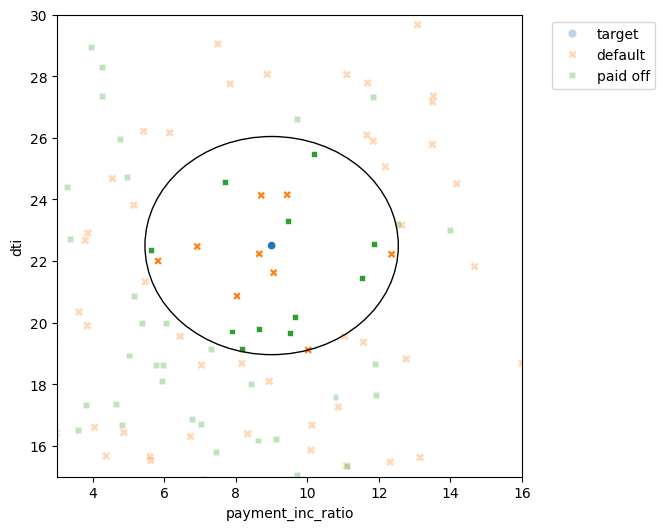

In [33]:
nbrs = knn.kneighbors(newloan)    # Find the k-nearest neighbors for 'newloan' using the trained KNN model
maxDistance = np.max(nbrs[0][0])  # Calculate the maximum distance to the nearest neighbors

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(6, 6))  # Set the size of the plot to be 6x6 inches

# Scatter plot of all loans with 'payment_inc_ratio' on x-axis and 'dti' on y-axis
sns.scatterplot(x='payment_inc_ratio', 
                y='dti', style='outcome',  # Style points by outcome ('default' or 'paid off')
                hue='outcome',             # Color points based on the outcome variable
                data=loan200,              # Use the 'loan200' dataset for this plot
                alpha=0.3, ax=ax)          # Set transparency to 30% to reduce overlapping effects

# Scatter plot for the 'newloan' and its nearest neighbors
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',  # Plot outcome to differentiate 'default' or 'paid off'
                hue='outcome',                                    # Color points based on outcome (same as before)
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1, :]]),  # Plot 'newloan' and its neighbors
                ax=ax, legend=False)                              # Use the same axis and disable additional legend

# Draw an ellipse around 'newloan' to indicate the neighborhood
ellipse = Ellipse(xy=newloan.values[0],    # Set the center of the ellipse at the location of 'newloan'
                  width=2 * maxDistance,   # Set the width of the ellipse to twice the max distance
                  height=2 * maxDistance,  # Set the height of the ellipse to twice the max distance
                  edgecolor='black',       # Set the edge color to black for visibility
                  fc='None',               # No fill color for the ellipse
                  lw=1)                    # Set the line width of the ellipse border to 1

ax.add_patch(ellipse)  # Add the ellipse to the plot

# Set limits for x and y axes to focus the plot area
ax.set_xlim(3, 16)   # Set x-axis limits to range from 3 to 16 for better visualization
ax.set_ylim(15, 30)  # Set y-axis limits to range from 15 to 30 for better visualization

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add a legend to describe the plot components

plt.show()           # Display the final plot

*KNN prediction of loan default using two variables: debt-to-income ratio and loan-payment-to-income ratio*

The new loan to be predicted is the circle in the middle. The squares (paid off) and cross (default) are the training data.
The large black circle shows the boundary of the nearest 20 points. In this case, 9
defaulted loans lie within the circle, as compared with 11 paid-off loans. Hence the
predicted outcome of the loan is paid off. Note that if we consider only three nearest
neighbors, the prediction would be that the loan defaults.

# Standardization (Normalization, Z-Scores)

For **KNN** and a few other procedures (e.g., **PCA** and **Clustering**), it is essential to consider standardizing the data prior to applying the procedure.

In [46]:
# Load the CSV data into a DataFrame
url2 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan_data.csv')  
loan_data = pd.read_csv(url2)

loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [48]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])          # Drop unnecessary columns ('Unnamed: 0' and 'status')

# Convert 'outcome' to a categorical variable with a specific order ('paid off' < 'default')
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],           # Convert 'outcome' column to a categorical type
                                      categories=['paid off', 'default'],  # Define the categories explicitly, setting 'paid off' < 'default'
                                      ordered=True)                   # Specify that the categories are ordered to give them meaningful ranking

# Define predictor variables and outcome variable
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']  # Features used to predict the outcome
outcome = 'outcome'                                                   # Define the target variable ('paid off' or 'default')

newloan = loan_data.loc[0:0, predictors]                              # Extract the feature values for the first loan (new loan to be predicted)

print(newloan)                                                        # Print the features of the new loan to verify the data
print()

# Split the data into training set (excluding the first row which is 'newloan')
X = loan_data.loc[1:, predictors]                                     # Extract features for the remaining loans to train the model
y = loan_data.loc[1:, outcome]                                        # Extract the outcome variable for the training data

# Initialize and fit K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier(n_neighbors=5)                             # Instantiate KNN model with 5 nearest neighbors
knn.fit(X, y)                                                         # Fit the KNN model to the training data

# Find the nearest neighbors for the new loan
nbrs = knn.kneighbors(newloan)                                        # Get the distances and indices of the nearest neighbors for 'newloan'
print(X.iloc[nbrs[1][0], :])                                          # Print the feature values of the 5 nearest neighbors to 'newloan'

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


The value of revol_bal in these neighbors is very close to its value in the new record,
but the other predictor variables are all over the map and essentially play no role in
determining neighbors.

In [52]:
newloan = loan_data.loc[0:0, predictors]  # Extract the feature values for the first loan

X = loan_data.loc[1:, predictors]         # Extract the feature values from the second row onwards
y = loan_data.loc[1:, outcome]            # Extract the outcome values for the training data

# Standardize the predictor variables
scaler = preprocessing.StandardScaler()  # Instantiate a StandardScaler to standardize the features
scaler.fit(X * 1.0)                      # Fit the scaler to the feature values, converting to float for scaling

# Transform the features to have a mean of 0 and standard deviation of 1
X_std = scaler.transform(X * 1.0)              # Standardize the training data (scale it based on the fitted scaler)
newloan_std = scaler.transform(newloan * 1.0)  # Standardize the new loan data using the same scaler

# Initialize and fit K-Nearest Neighbors (KNN) model using standardized data
knn = KNeighborsClassifier(n_neighbors=5)      # Instantiate KNN model with 5 nearest neighbors
knn.fit(X_std, y)                              # Fit the KNN model to the standardized training data and labels

# Find the nearest neighbors for the standardized new loan
nbrs = knn.kneighbors(newloan_std)             # Get the distances and indices of the nearest neighbors for 'newloan_std'

# Print the feature values of the 5 nearest neighbors (original unstandardized values for interpretation)
print(X.iloc[nbrs[1][0], :])                   # Print the feature values of the nearest neighbors in their original (unstandardized) form

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


The five nearest neighbors are much more alike in all the variables, providing a more
sensible result. Note that the results are displayed on the original scale, but KNN was
applied to the scaled data and the new loan to be predicted.

**Normalization (standardization) does not change the distributional shape of the data; it does not make it normally shaped if it was not
already normally shaped.**

# KNN as a Feature Engine